In [ ]:
#inport dataset 
from google.colab import files
uploaded = files.upload()

Saving case_time_series (1).csv to case_time_series (1) (1).csv


In [ ]:
#inport essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#read the data
df = pd.read_csv("case_time_series (1).csv")
df.tail()

,Date,Date_YMD,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
529,12 July 2021,2021-07-12,30818,30904515,47544,30054587,2024,410225
530,13 July 2021,2021-07-13,40314,30944829,42436,30097023,625,410850
531,14 July 2021,2021-07-14,41759,30986588,39293,30136316,578,411428
532,15 July 2021,2021-07-15,39071,31025659,39827,30176143,544,411972
533,16 July 2021,2021-07-16,38115,31063774,43878,30220021,560,412532


Preprocessing


In [ ]:
#getting the shape of dataset
df.shape

(534, 8)

In [ ]:
#getting information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             534 non-null    object
 1   Date_YMD         534 non-null    object
 2   Daily Confirmed  534 non-null    int64 
 3   Total Confirmed  534 non-null    int64 
 4   Daily Recovered  534 non-null    int64 
 5   Total Recovered  534 non-null    int64 
 6   Daily Deceased   534 non-null    int64 
 7   Total Deceased   534 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 33.5+ KB


In [ ]:
#describing the datset
df.describe()

,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
count,534.000000,5.340000e+02,534.000000,5.340000e+02,534.000000,534.000000
mean,58171.861423,8.730452e+06,56591.799625,8.008350e+06,772.531835,117321.507491
std,85044.137019,9.235361e+06,83090.405194,8.680325e+06,1049.852990,113290.860515
min,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,9880.500000,3.011195e+05,6974.000000,1.487878e+05,113.250000,8598.000000
50%,30749.500000,7.786710e+06,29483.500000,6.980044e+06,436.000000,117078.500000
75%,64102.250000,1.118724e+07,64046.750000,1.084848e+07,927.000000,157074.750000
max,414280.000000,3.106377e+07,422391.000000,3.022002e+07,6139.000000,412532.000000


In [ ]:
# Storethe data in variables
x = np.array(df['Total Confirmed'])
y = np.array(df['Total Recovered'])
z = np.array(df['Total Deceased'])
N = 1370508600

In [ ]:
#make the array of susceptible, Infected and Removed peoples
sus = np.array(N-x)[-200:]
inf = np.array(x-y-z)[-200:]
rec = np.array(y+z)[-200:]

In [ ]:
# Make the function to find the beta
# beta is average number of contacts per person per time 
def find_beta(sus,inf,N):
  beta = np.zeros(len(sus)-1)
  for i in range(len(sus)-1):
    beta[i] = -((sus[i+1] - sus[i])*N)/(sus[i]*inf[i])
  return beta

In [ ]:
#  Make the function to find gamma
# gamma is probability of an infectious individual recovering in any time interval
def find_gamma(inf,rec):
  gamma = np.zeros(len(rec)-1)
  for i in range(len(rec)-1):
    gamma[i] = (rec[i+1]-rec[i])/(inf[i])
  return gamma

In [ ]:
# Do train_test_split of the infected, susceptible and recovered peoples
from sklearn.model_selection import train_test_split
sus_train, sus_test, inf_train, inf_test, rec_train, rec_test = train_test_split(sus, inf, rec, test_size=0.2, shuffle=False)

In [ ]:
# Find the beta on training set and the testing set
beta = find_beta(sus_train,inf_train,N)
gamma = find_gamma(inf_train,rec_train)
# This beta and gamma are fot validation of prediction
beta_o = find_beta(sus_test,inf_test,N)
gamma_o = find_gamma(inf_test,rec_test)

In [ ]:
# Make the variable to predict the number of days
pdays = len(sus_test)
# form the dataset for alpha and beta
beta_1 = pd.DataFrame(data=beta,columns= ['Beta'])
gamma_1 = pd.DataFrame(data=gamma,columns = ['Gamma'])
beta_1['beta_p'] = beta_1[['Beta']].shift(-pdays)
gamma_1['gamma_p'] = gamma_1[['Gamma']].shift(-pdays)

In [ ]:
# Create the array to fit the model
x_1 = np.array(beta_1['Beta']).reshape(-1,1)[:-pdays]
y_1 = np.array(beta_1['beta_p']).reshape(-1,1)[:-pdays]
x_2 = np.array(gamma_1['Gamma']).reshape(-1,1)[:-pdays]
y_2 = np.array(gamma_1['gamma_p']).reshape(-1,1)[:-pdays]
# Create the array to predict the beta and gamma
b_test = np.array(beta_1['Beta']).reshape(-1,1)[-pdays:]
g_test = np.array(gamma_1['Gamma']).reshape(-1,1)[-pdays:]

Model Fitting 

In [ ]:
# Fit the decision tree regressor model to predict beta and gamma
from sklearn.tree import DecisionTreeRegressor
tree_1 = DecisionTreeRegressor().fit(x_1,y_1)
tree_2 = DecisionTreeRegressor().fit(x_2,y_2)

In [ ]:
# Fit the Random Forest Regressor model to preditct beta and gamma
from sklearn.ensemble import RandomForestRegressor
rfreg_1 = RandomForestRegressor().fit(x_1, y_1)
rfreg_2 = RandomForestRegressor().fit(x_2, y_2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [ ]:
# Predict the value of beta and gamma for Decision tree regressor
prediction_b = tree_1.predict((b_test))
prediction_g = tree_2.predict((g_test))

In [ ]:
# Predict the vlaues of beta and gamma for Random Forest regressor
predict_rf_b = rfreg_1.predict((b_test))
predict_rf_g = rfreg_2.predict((g_test))

In [ ]:
# Make the empty array to predict the redults 
S_1 = np.zeros(pdays)
I_1 = np.zeros(pdays)
R_1 = np.zeros(pdays)
# Find the present Susceptible, Infected and Recovered peoples and set it into zeroth index
S_1[0] = sus[len(sus_train)]
I_1[0] = inf[len(inf_train)]
R_1[0] = rec[len(rec_train)] 
# Store the prediction of Decision Tree Regressor in variables 
beta_1 = prediction_b
gamma_1 = prediction_g

In [ ]:
# Predict the result using Eulars Integration method
for i in range(len(prediction_b)-1):
  S_1[i+1] = S_1[i] - (beta_1[i]*S_1[i]*I_1[i]/N)
  I_1[i+1] = I_1[i] - ((beta_1[i]*S_1[i]*I_1[i]/N) - gamma_1[i]*I_1[i])
  R_1[i+1] = R_1[i] + (gamma_1[i]*I_1[i])

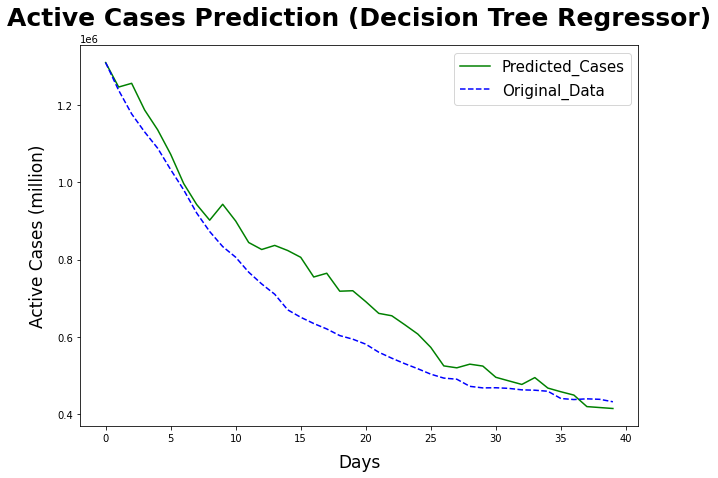

In [ ]:
# Visualising the Predictions of Decision tree regressor model
plt.figure(figsize = (10,7))
plt.title('Active Cases Prediction (Decision Tree Regressor)', fontsize = 25, fontweight = 'bold', pad = 20)
plt.xlabel('Days', fontsize = 17, labelpad = 10, )
plt.ylabel('Active Cases (million)', fontsize = 17, labelpad = 10, )
plt.plot(I_1,'-g')
plt.plot(inf_test, '--b')
plt.legend(['Predicted_Cases','Original_Data'], fontsize = 15 )
plt.savefig('Decision tree.png')

In [ ]:
from sklearn.metrics import r2_score
tree_score = r2_score(I_1, inf_test)
tree_score

0.9056301694042033

In [ ]:
# Make the empty array to predict the results 
S = np.zeros(pdays)
I = np.zeros(pdays)
R = np.zeros(pdays)
# Find the present Susceptible, Infected and Recovered peoples and set it into zeroth index
S[0] = sus[len(sus_train)]
I[0] = inf[len(inf_train)]
R[0] = rec[len(rec_train)] 
# Store the prediction of Decision Tree Regressor in variables 
beta = predict_rf_b
gamma = predict_rf_g

In [ ]:
# Predict the result using Eulars Integration method
for i in range(len(prediction_b)-1):
  S[i+1] = S[i] - (beta[i]*S[i]*I[i]/N)
  I[i+1] = I[i] - ((beta[i]*S[i]*I[i]/N) - gamma[i]*I[i])
  R[i+1] = R[i] + (gamma[i]*I[i])

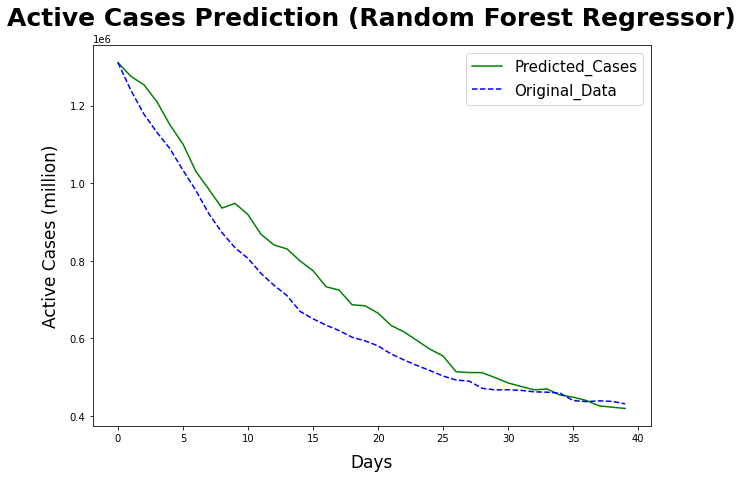

In [ ]:
# Visualising the Predictions of Decision tree regressor model
plt.figure(figsize = (10,7))
plt.title('Active Cases Prediction (Random Forest Regressor)', fontsize = 25, fontweight = 'bold', pad = 20)
plt.xlabel('Days', fontsize = 17, labelpad = 10 )
plt.ylabel('Active Cases (million)', fontsize = 17, labelpad = 10)
plt.plot(I,'-g')
plt.plot(inf_test, '--b')
plt.legend(['Predicted_Cases','Original_Data'], fontsize = 15 )
plt.savefig('random forest.png')

Results 

In [ ]:
#calculating the r2_score to validate the predictions
forest_score = r2_score(I, inf_test)
forest_score

0.9324393369573706